# Electricity Price Prediction | ML Zoomcamp Cap Stone #1 Project

## Data Exploration

### Library import and dataload

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
energy_data = pd.read_csv(r"data/energy_dataset.csv")

### Initial peak at the data

In [3]:
energy_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 29 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35045 non-null  float64
 2   generation fossil brown coal/lignite         35046 non-null  float64
 3   generation fossil coal-derived gas           35046 non-null  float64
 4   generation fossil gas                        35046 non-null  float64
 5   generation fossil hard coal                  35046 non-null  float64
 6   generation fossil oil                        35045 non-null  float64
 7   generation fossil oil shale                  35046 non-null  float64
 8   generation fossil peat                       35046 non-null  float64
 9   generation geothermal                        35046 non-null  float64
 10

Ok, so a lot of columns (29 in total) almost all of them numeric and I would group them in 5 major groups:
* time - it reads like an object so we should cast it to pandas datetime
* power generation by the different types of energy source
  * some of them seem to not hold any value and thus should be discarded and I also wonder about non-null values fluctuations between them - maybe not all of them are used
* renewable energy forecasts (solar and wind on and off shore)
  * as we have the weather data in the other dataset we might want to drop these
* power demand (aka load) actual and forecasted at each datapoint (hour)
* prices for each moment (actual - our target variable - and for day ahead)

Let's see how the data looks like:

In [4]:
energy_data.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
generation biomass,35045.0,383.51,85.35,0.00,333.00,367.00,433.00,592.00
generation fossil brown coal/lignite,35046.0,448.06,354.57,0.00,0.00,509.00,757.00,999.00
generation fossil coal-derived gas,35046.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
generation fossil gas,35046.0,5622.74,2201.83,0.00,4126.00,4969.00,6429.00,20034.00
generation fossil hard coal,35046.0,4256.07,1961.60,0.00,2527.00,4474.00,5838.75,8359.00
generation fossil oil,35045.0,298.32,52.52,0.00,263.00,300.00,330.00,449.00
generation fossil oil shale,35046.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
generation fossil peat,35046.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
generation geothermal,35046.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
generation hydro pumped storage aggregated,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Ok, interesting, so it seems like a lot of the generation sources do not have any values other than 0 or null - it makes sense as the country in question (Spain) does not have all the types of energy generated, namely: ```generation fossil coal-derived gas```, ```ggeneration fossil oil shale```, ```generation fossil peat```, ```generation geothermal```, ```generation marine```, ```generation wind offshore``` and ```generation hydro pumped storage aggregated```.

For all the other their values vary between 0 and whatever their peak is and load and prices never reach 0, which makes sense has the country has always demand for power.

Going forward I will drop all the columns stated above that are irrevelant and let's see how their chart looks like.

In [5]:
generation_columns = [
    'generation biomass', 'generation fossil brown coal/lignite',
    'generation fossil gas', 'generation fossil hard coal', 
    'generation fossil oil',
    'generation hydro pumped storage consumption',
    'generation hydro run-of-river and poundage',
    'generation hydro water reservoir',
    'generation nuclear', 'generation other', 'generation other renewable',
    'generation solar', 'generation waste',
    'generation wind onshore']

forecast_columns = ['forecast solar day ahead','forecast wind onshore day ahead']

demand_columns = ['total load actual', 'total load forecast']

price_columns = ['price day ahead', 'price actual']

energy_data['time'] = pd.to_datetime(energy_data['time'], utc=True, errors='coerce')

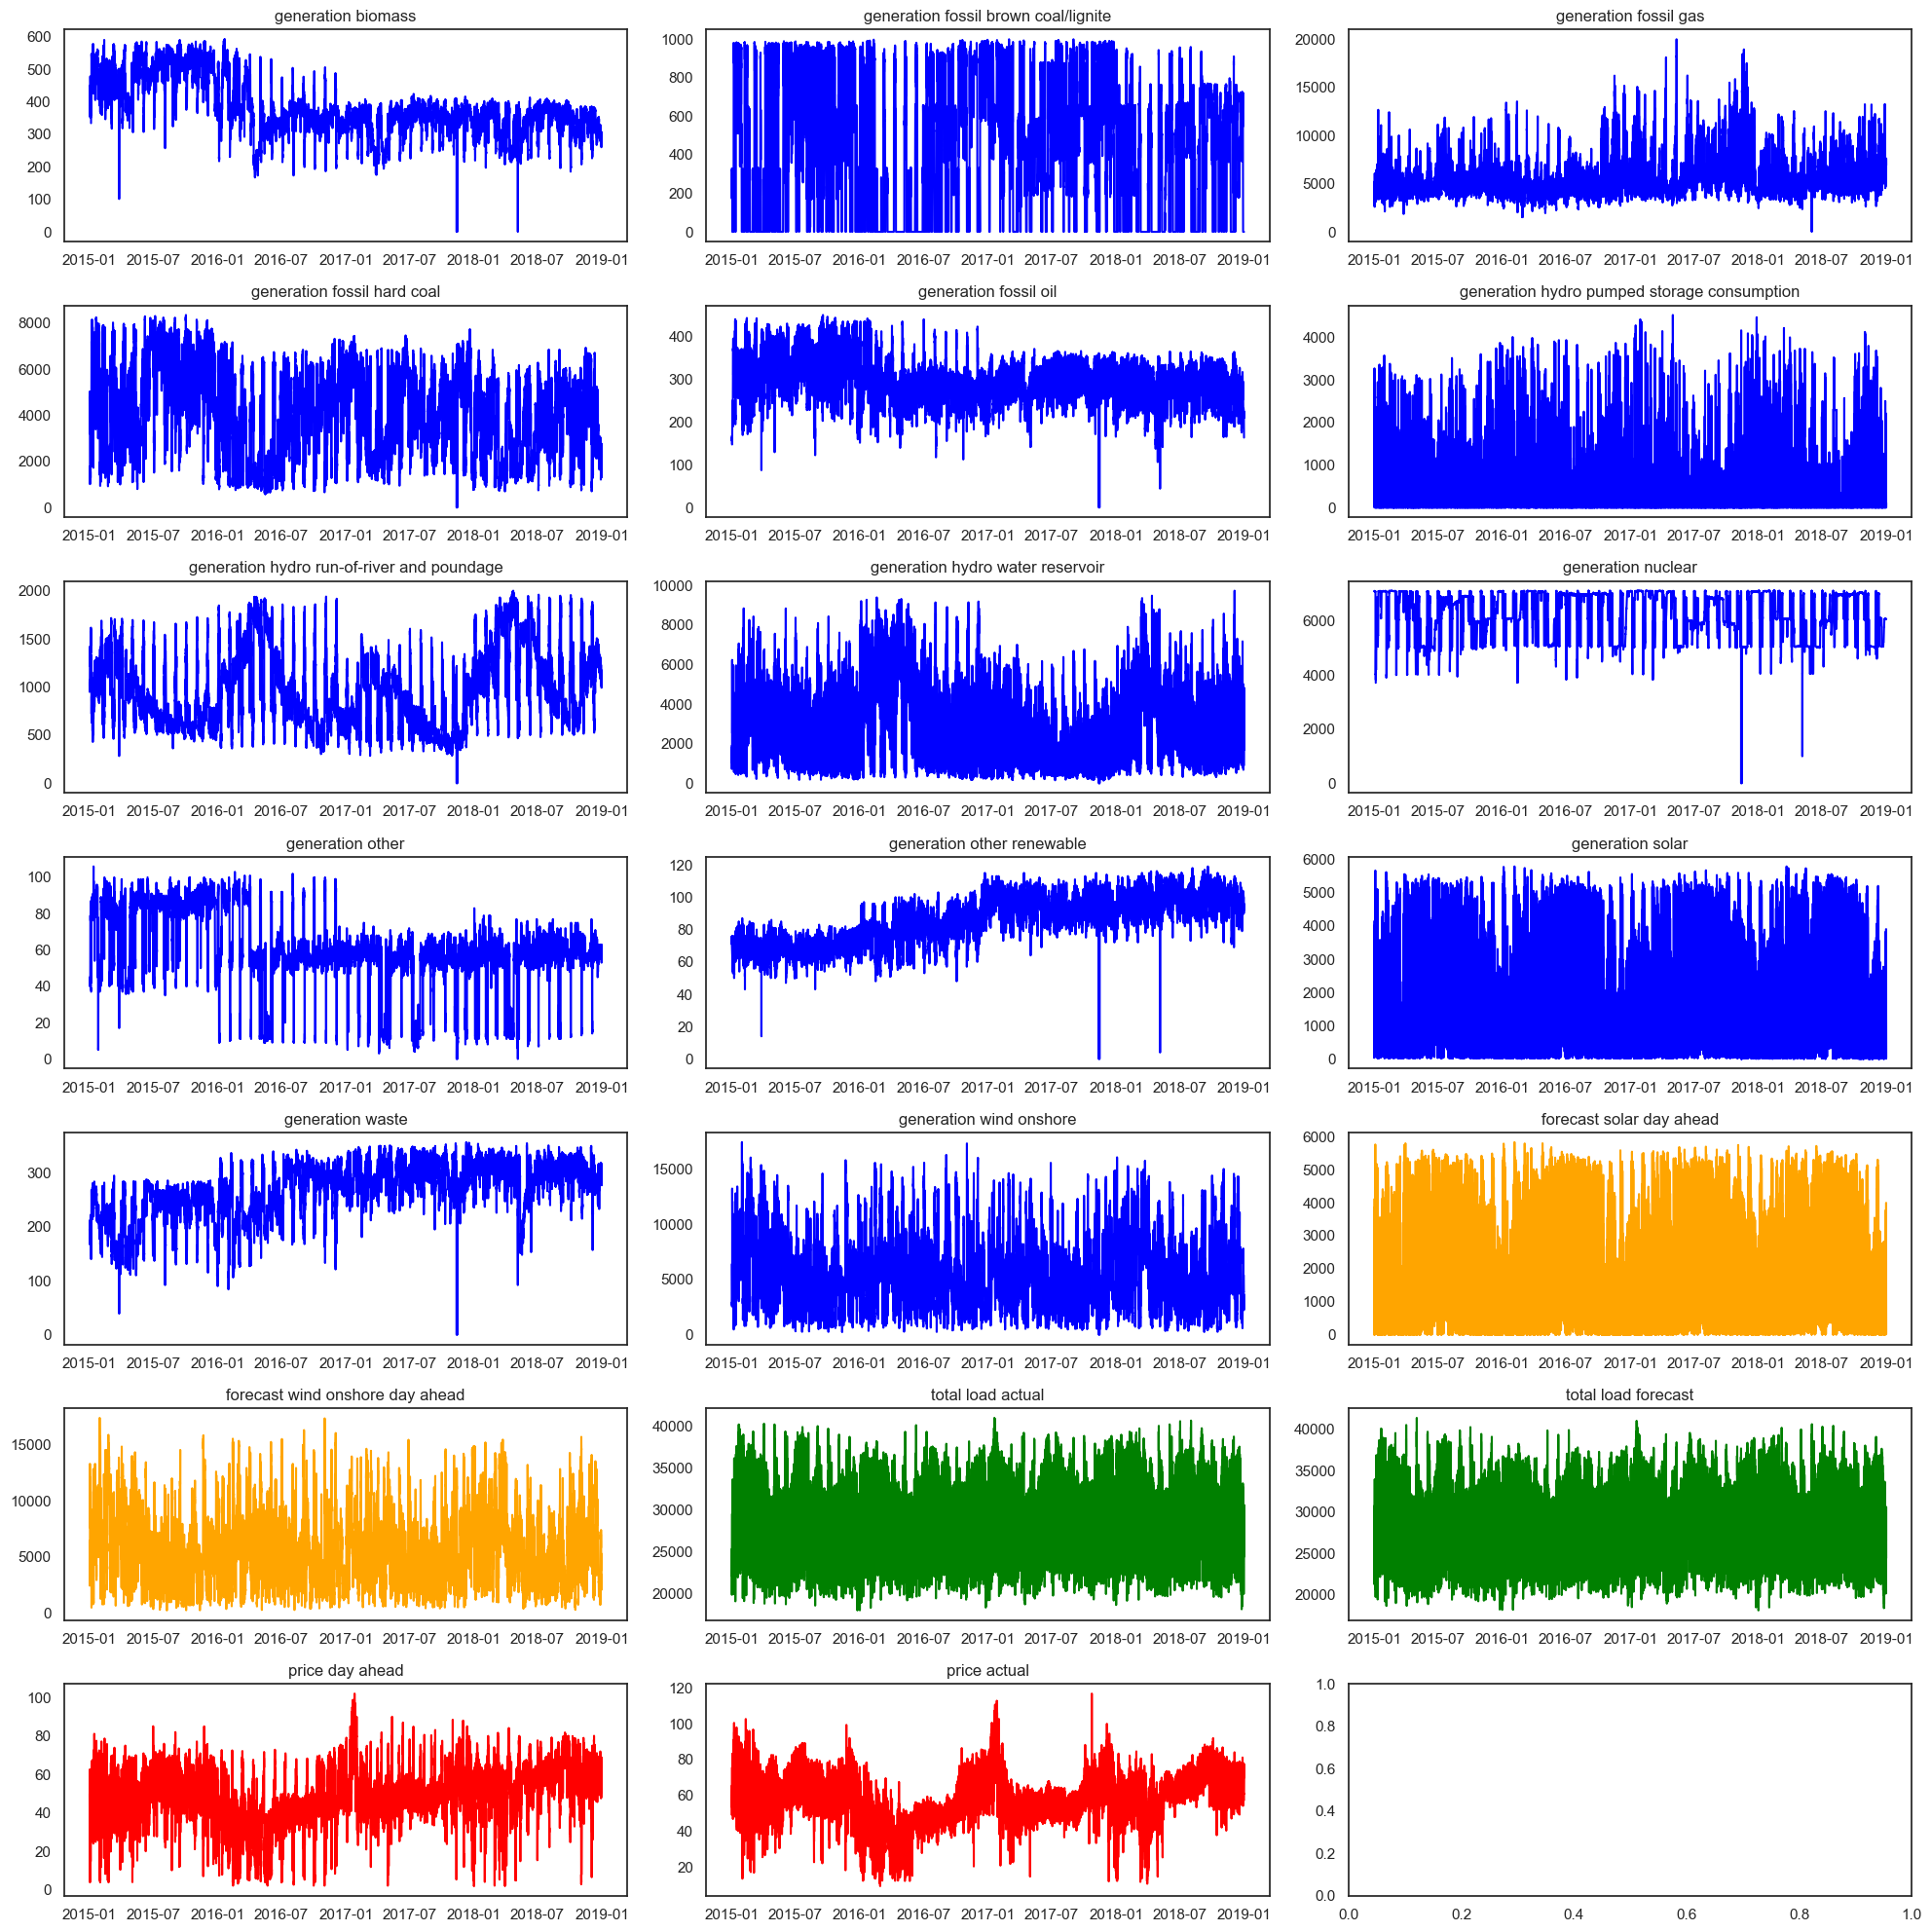

In [6]:
generation_color = 'blue'
forecast_color = 'orange'
demand_color = 'green'
price_color = 'red'

column_color_mapping = {col: generation_color for col in generation_columns}
column_color_mapping.update({col: forecast_color for col in forecast_columns})
column_color_mapping.update({col: demand_color for col in demand_columns})
column_color_mapping.update({col: price_color for col in price_columns})

all_columns = generation_columns + forecast_columns + demand_columns + price_columns

sns.set(style="white")

num_rows = 7
num_cols = 3

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))
axes = axes.flatten()

for i, col in enumerate(all_columns):
    ax = axes[i]
    ax.plot(energy_data['time'], energy_data[col], label=col, color=column_color_mapping[col])
    ax.set_title(col)

plt.tight_layout()
plt.show()

Look at those nice colours! Let's see what they are telling us:
#### Generation (blue)
* Each generation form seems to follow its own pattern - some, like ```other renewable``` or ```waste```, show a growing trend whereas ```biomass``` or ```oil``` have a clear decline halfway thru 2016 and ```hard coal``` also seems to be declining.
* Renewable energy like ```wind onshore```, ```solar``` and ```hydro``` show clear signs of seasonality - which is natural for these sources.
* In contrast to the ones above, due to its nature ```nuclear``` seems pretty stationary as well as ```gas```.
* Some sources seem to compensate for other - e.g.: ```fossil gas``` seems to have a peak period in early 2017 when ```solar``` seems to be quite low which means there are some relations between them.
* The sudden drops observed in some sources seems plausible given the generation cycle during the days / seasons. We should just need to take a look to ensure these are not because of the null values an correct for those - let's think about that later.
#### Renewable Forecasts (orange)
* They seem pretty aligned with the actual generation for the corresponding source, so most likely they should be taken out of the training data as they are redundant.
#### Load (green)
* Forecast and actual load show pretty similar pattern, so probably the forecast is something that could be made redundant as well.
#### Prices (red)
* Price day ahead shows a lot more spikes than the price actual - most likely I also won't want to use that one.
* Price pattern and fluctuations seem quite different before 2016 and after 2016 - probably related with the generation mix changes originated from ```coal``` and ```oil``` around that period.
* Interesting to observe that price peaks in early 2017 and 2018 also seem to correspond with peaks in ```gas``` related generation.

In sum:
* We need to prep the data for nulls
* We need to deal with seasonal and non-stationary series - meaning we are going the scale the data
* We might want to remove some redundant columns
* It might be worth to discard past data (e.g: before 2016) as the nature of the generation mix might not be relevant going into the future and also to make the computation lighter.
 
Let's continue and address these issues starting with this last one about the relevance of past data:

### Structure of generation mix before and after 2016

Let's start by looking at the generation mix evolution on a monthly basis as we saw from the charts above that hourly data is too noisy.

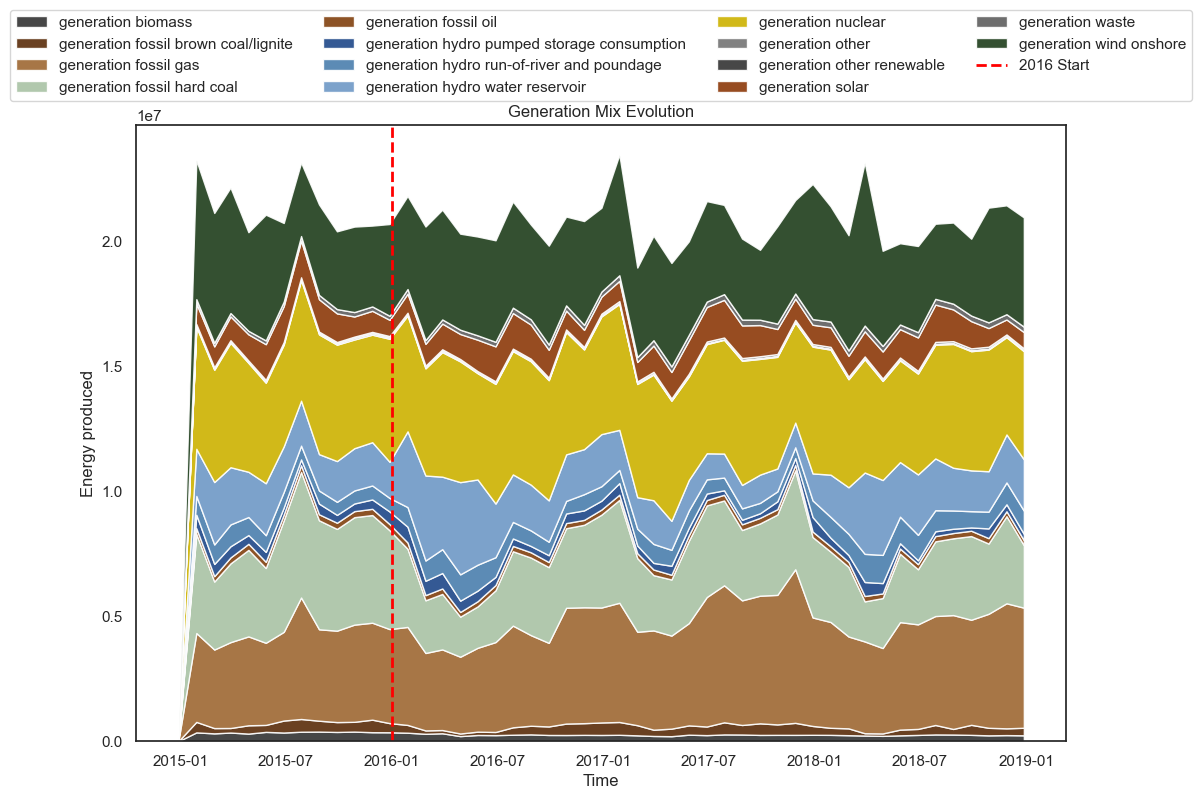

In [7]:
grouped_columns = generation_columns + ['month','year']
energy_data['month'] = energy_data['time'].dt.month
energy_data['year'] = energy_data['time'].dt.year
grouped_df = energy_data[grouped_columns].groupby(['year', 'month']).sum().reset_index()
grouped_df['date'] = pd.to_datetime(grouped_df[['year', 'month']].assign(day=28))
grouped_df = grouped_df.drop(['year', 'month'], axis=1)

# Create a custom color palette for generation source visualization
brown_palette = sns.color_palette(['#5A2C0A', '#9E6732', '#A9C2A4', '#81400E'])
blue_palette = sns.color_palette(['#1E4788', '#4A7FAD', '#6E98C6'])
yellow_palette = sns.color_palette(['#CCB200'])
gray_palette = sns.color_palette(['#737373', '#333333', '#5E5E5E'])
orange_palette = sns.color_palette(['#8C3809'])
green_palette = sns.color_palette(['#1E3D1A'])

# Map each column to its corresponding color based on the specified groups
column_color_mapping = {
    'generation fossil brown coal/lignite': brown_palette[0],
    'generation fossil gas': brown_palette[1],
    'generation fossil hard coal': brown_palette[2],
    'generation fossil oil': brown_palette[3],
    'generation hydro pumped storage consumption': blue_palette[0],
    'generation hydro run-of-river and poundage': blue_palette[1],
    'generation hydro water reservoir': blue_palette[2],
    'generation nuclear': yellow_palette[0],
    'generation other': gray_palette[0],
    'generation other renewable': gray_palette[1],
    'generation biomass': gray_palette[1],
    'generation waste': gray_palette[2],
    'generation solar': orange_palette[0],
    'generation wind onshore': green_palette[0]
}

plt.figure(figsize=(12, 8))

plt.stackplot(
    grouped_df['date'],
    [grouped_df[col] for col in generation_columns],
    labels=generation_columns,
    colors=[column_color_mapping[col] for col in generation_columns],
    alpha=0.9
)

# Add a red vertical dashed line at the beginning of 2016
plt.axvline(pd.Timestamp('2016-01-01'), color='red', linestyle='--', linewidth=2, label='2016 Start')

plt.title('Generation Mix Evolution')
plt.xlabel('Time')
plt.ylabel('Energy produced')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=4)

plt.show()

Unfortunately, even the monthly data seems messy and although it definitly looks like coal had a higher weight before 2016, it is not 100% clear from the chart above. Also we are not seeing how it affected our target variable - price, so let's try something different.

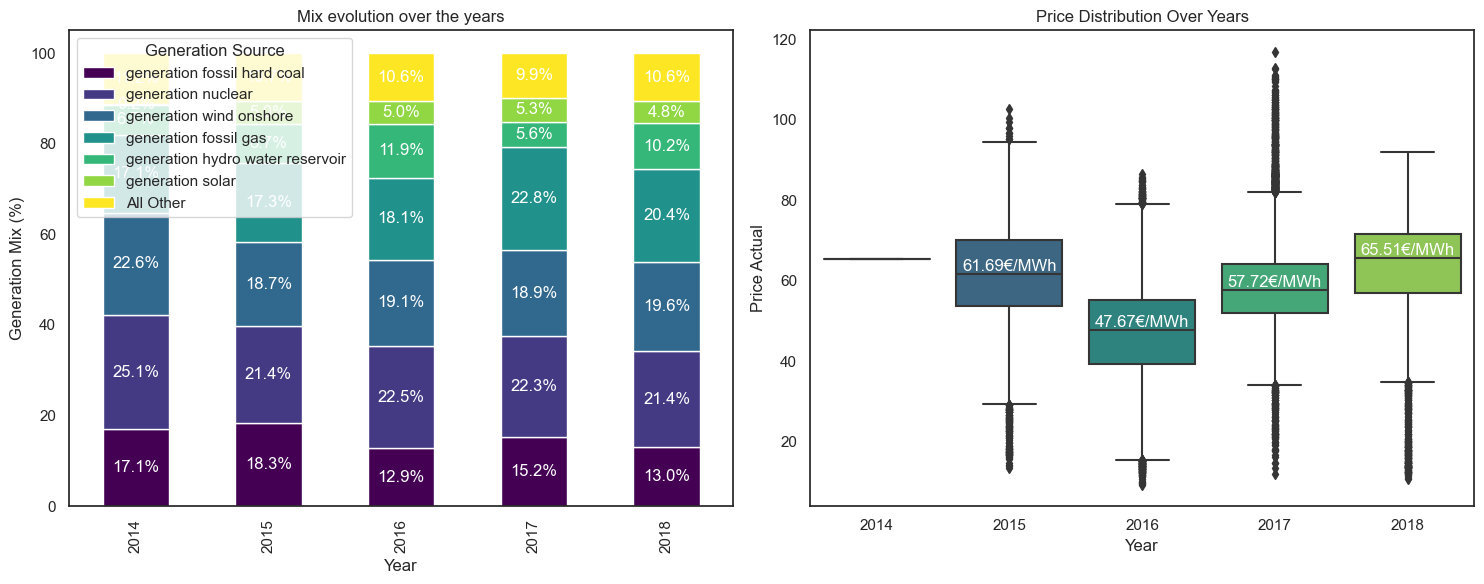

In [8]:
top_sources = ['generation fossil hard coal', 'generation nuclear', 'generation wind onshore', 
                     'generation fossil gas', 'generation hydro water reservoir', 'generation solar']

# Create a new DataFrame with selected columns
selected_generation = energy_data[['time', 'price actual'] + top_sources].copy()

# Calculate the sum of all other sources and add a new column 'All Other'
selected_generation['All Other'] = energy_data[generation_columns].sum(axis=1) - selected_generation[top_sources].sum(axis=1)

# Extract year from the 'time' column
selected_generation['year'] = selected_generation['time'].dt.year

# Create subplots for the generation mix and price distribution
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Stacked bar chart for the generation mix with percentage labels
generation_data = selected_generation.groupby('year')[top_sources + ['All Other']].sum()
generation_data_percentage = generation_data.div(generation_data.sum(axis=1), axis=0) * 100
generation_data_percentage.plot(kind='bar', stacked=True, colormap='viridis', ax=axs[0])

axs[0].set_title('Mix evolution over the years')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Generation Mix (%)')
axs[0].legend(title='Generation Source', loc='upper left', ncol=1)

# Add percentage labels to the stacked bar chart
for i in range(generation_data_percentage.shape[0]):
    total = 0
    for j, value in enumerate(generation_data_percentage.iloc[i]):
        axs[0].text(i, total + value / 2, f'{value:.1f}%', ha='center', va='center', color='white')
        total += value

# Box plot for the price distribution
sns.boxplot(x='year', y='price actual', data=selected_generation, palette='viridis', ax=axs[1])
axs[1].set_title('Price Distribution Over Years')
axs[1].set_xlabel('Year')
axs[1].set_ylabel('Price Actual')

medians = selected_generation.groupby('year')['price actual'].median()
for i, median_value in enumerate(medians):
    axs[1].text(i, median_value, f'{median_value:.2f}€/MWh', ha='center', va='bottom', color='white')


plt.tight_layout()
plt.show()

Ok, perfect so we clearly see that coal had a much higher weight in the generation mix before 2016 (~18% vs. ~13%)which reflected on a different price structure. In order to have the model not being too influenced from this past reality (that shouldn't repeat itself going forward as probably some coal plants have been decomissioned already) we should start our adventure from 2016 onwards.

In [9]:
energy_data = energy_data[energy_data['time'] >= '2016-01-01']

### Handling Nulls

In [10]:
energy_data[generation_columns + forecast_columns + demand_columns + price_columns].isnull().sum()

generation biomass                             3
generation fossil brown coal/lignite           2
generation fossil gas                          2
generation fossil hard coal                    2
generation fossil oil                          3
generation hydro pumped storage consumption    3
generation hydro run-of-river and poundage     3
generation hydro water reservoir               2
generation nuclear                             1
generation other                               2
generation other renewable                     2
generation solar                               2
generation waste                               3
generation wind onshore                        2
forecast solar day ahead                       0
forecast wind onshore day ahead                0
total load actual                              9
total load forecast                            0
price day ahead                                0
price actual                                   0
dtype: int64

Given that ```total load actual``` is the one of the variables with most missing values let's have a detailed look at those.

In [11]:
energy_data[energy_data['total load actual'].isnull()].head(5)

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual,month,year
11524,2016-04-25 03:00:00+00:00,190.0,0.0,0.0,2969.0,886.0,151.0,0.0,0.0,0.0,...,5989.0,412.0,NaN,6019.0,21471.0,NaN,15.00,22.65,4,2016
11526,2016-04-25 05:00:00+00:00,206.0,0.0,0.0,3673.0,1143.0,185.0,0.0,0.0,0.0,...,5682.0,208.0,NaN,5758.0,27635.0,NaN,32.97,40.18,4,2016
11902,2016-05-10 21:00:00+00:00,348.0,960.0,0.0,6800.0,5219.0,299.0,0.0,0.0,0.0,...,3311.0,84.0,NaN,3465.0,26641.0,NaN,51.57,39.11,5,2016
13341,2016-07-09 20:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,499.0,NaN,4914.0,34985.0,NaN,45.72,51.72,7,2016
15272,2016-09-28 07:00:00+00:00,347.0,594.0,0.0,5522.0,6272.0,292.0,0.0,0.0,0.0,...,5478.0,967.0,NaN,5359.0,31072.0,NaN,49.72,56.40,9,2016


Ok, so we have some nulls just at the beginning of the dataset so let's plot the first two weeks of data to see how it looks like.

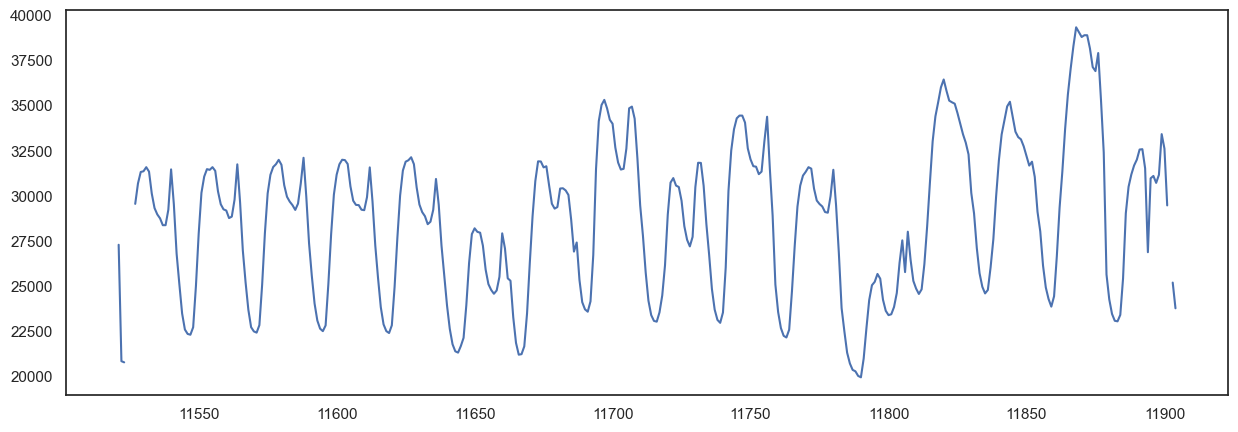

In [12]:
null_period_start_date = '2016-04-25'
null_period_end_date = '2016-05-11'
filtered_data = energy_data[(energy_data['time'] >= null_period_start_date) & (energy_data['time'] < null_period_end_date)]

plt.rcParams['figure.figsize'] = (15, 5)
plt.plot(filtered_data['total load actual'])

It seems like some hours are missing. To try to respect the original shape of the data, let's try to fill-in the missing values with the linear interpolation of those.

In [13]:
energy_data.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

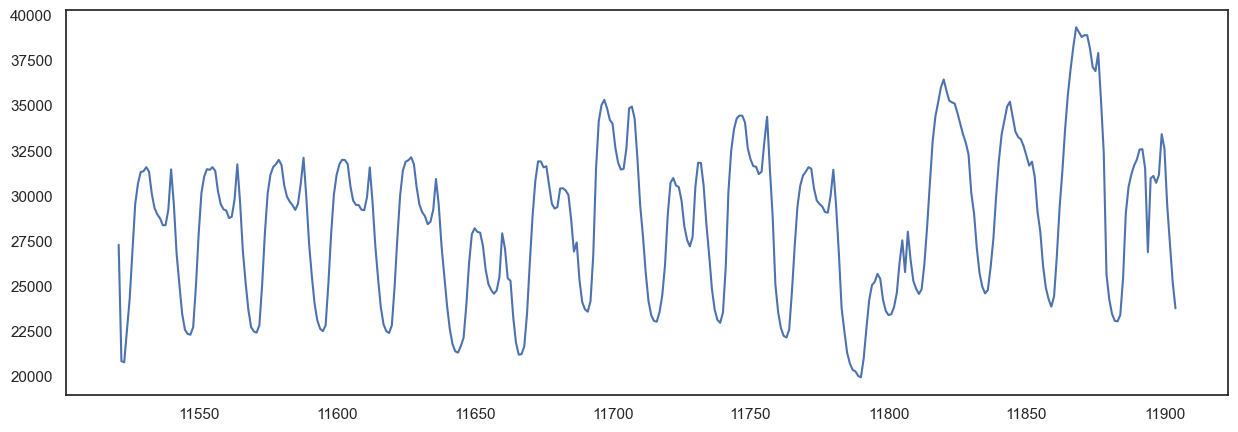

In [14]:
null_period_start_date = '2016-04-25'
null_period_end_date = '2016-05-11'
filtered_data = energy_data[(energy_data['time'] >= null_period_start_date) & (energy_data['time'] < null_period_end_date)]

plt.rcParams['figure.figsize'] = (15, 5)
plt.plot(filtered_data['total load actual'])

Ok, seems good enough.

In [15]:
energy_data[generation_columns + forecast_columns + demand_columns + price_columns].isnull().sum()

generation biomass                             0
generation fossil brown coal/lignite           0
generation fossil gas                          0
generation fossil hard coal                    0
generation fossil oil                          0
generation hydro pumped storage consumption    0
generation hydro run-of-river and poundage     0
generation hydro water reservoir               0
generation nuclear                             0
generation other                               0
generation other renewable                     0
generation solar                               0
generation waste                               0
generation wind onshore                        0
forecast solar day ahead                       0
forecast wind onshore day ahead                0
total load actual                              0
total load forecast                            0
price day ahead                                0
price actual                                   0
dtype: int64

### Skewness analysis

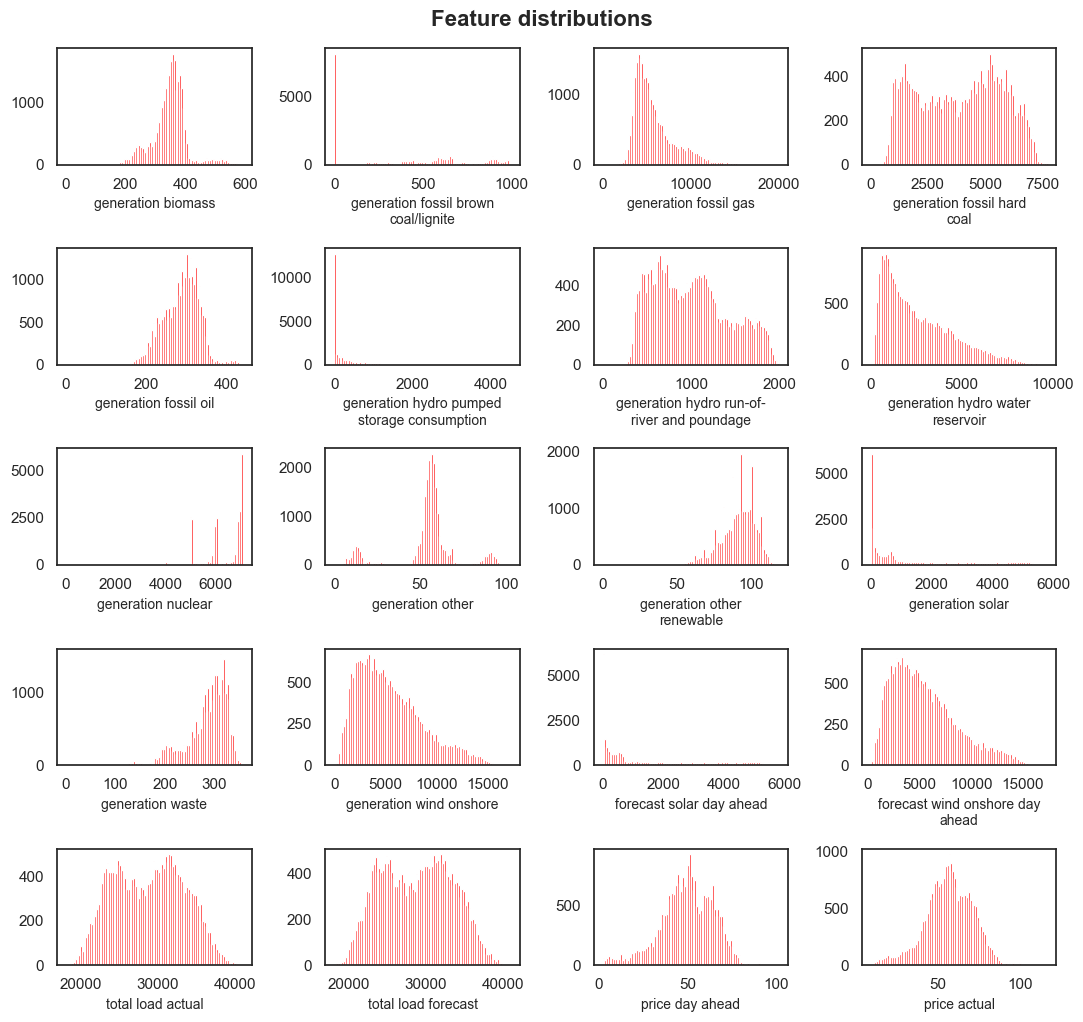

In [16]:
from textwrap import wrap
numerical = generation_columns + forecast_columns + demand_columns + price_columns
fig, axs = plt.subplots(5, 4, figsize=(11,10))
for col, ax in zip(energy_data[numerical].columns, axs.ravel()):
    if energy_data[numerical][col].dtype == float:
        ax.hist(energy_data[numerical][col], bins=100, color='red')
    else: #int
        vc = energy_data[numerical][col].value_counts()
        ax.bar(vc.index, vc, color='red')
    ax.set_xlabel('\n'.join(wrap(col,25)), fontsize=10)
plt.tight_layout()
plt.suptitle('Feature distributions', y=1.02, fontsize=16, fontweight = "bold")
plt.show()

Ok, so let's break this down:
* ```price actual``` shows a normal distribution, which is great for our goal
* ```price day ahead```, ```total load actual```, ```total load forecast```, ```generation biomass```, ```generation fossil hard coal```, ```generation fossil oil``` all also show some kind of normal distribution.
* Renewable energies (```wind onshore```, ```hydro``` and ```solar```) all show some skeweness to the right, excep ```generation other renewable```.
* ```generation nuclear``` is skewed to the right and ```generation fossil gas``` is skewed to the left.

Despite the skeweness in some input variables, as we will need to scale the values anyway to deal with the seasonality and trends I have opted not to do further transformations to the data here.

### Feature correlation / importance

Text(0.5, 1.0, 'Dataset correlation matrix')

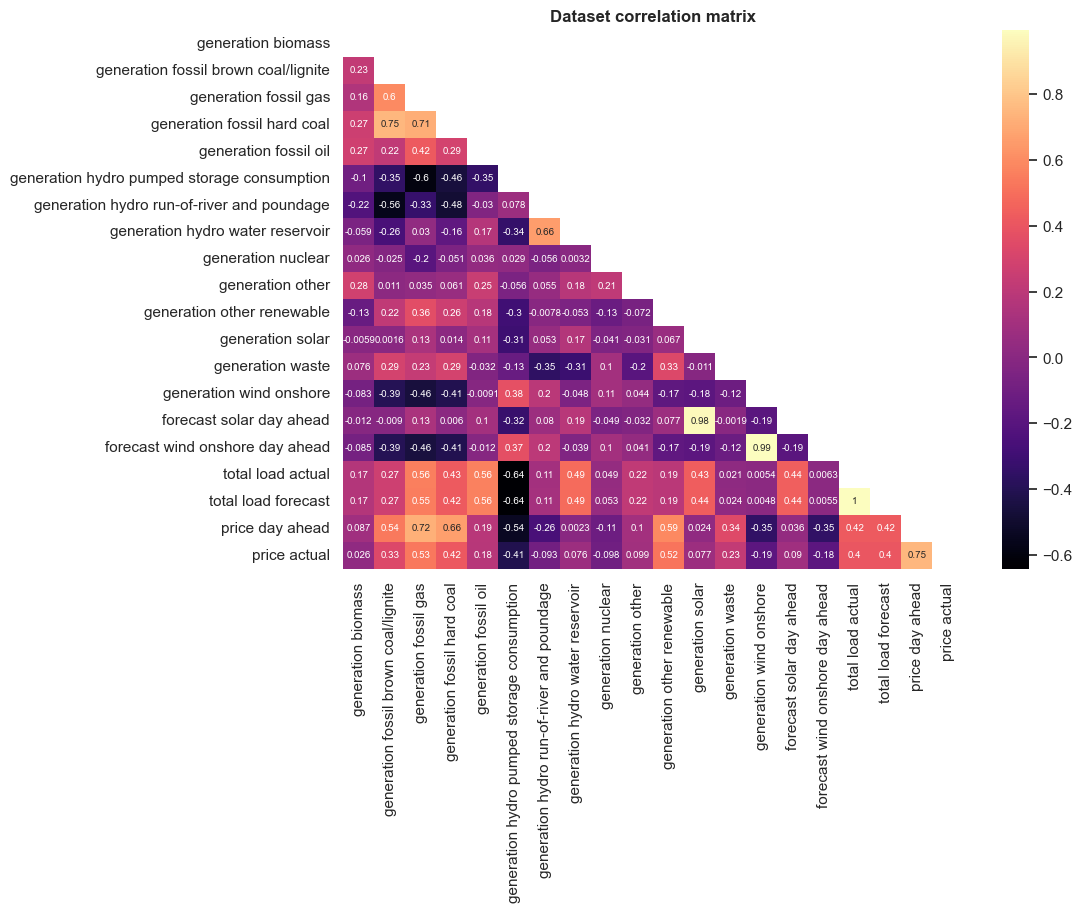

In [17]:
corr = energy_data[numerical].corr(method = "spearman")
plt.figure(figsize = (10, 7))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, cmap = "magma", annot = True, annot_kws = {'size': 7})
plt.title("Dataset correlation matrix", fontsize = 12, fontweight = "bold")

Except for ```price day ahead``` we don't seem to have a very strong correlation between neither of the variables and our target (```price day actual```).

Without surprise however, we can observe that ```generation fossil gas``` and ```generation fossil hard coal``` alongside with ```load``` variables are the ones that most relate to the price, as the amount of fossil fuels used and the demand has a direct impact on the price.

Interesting to observe also that renewable forecasts have a slightly higher correlation with the target variable than the actual generation variables (e.g.: ```generation solar``` is just 0.13 whereas ```forecast solar day ahead``` is just 0.14). As such we will leave both these variables in the model.

Also seems like whenever ```hydro``` is pumped it has a significant effect on price (more than just normal ```hydro``` generation)

#### Auto-correlation

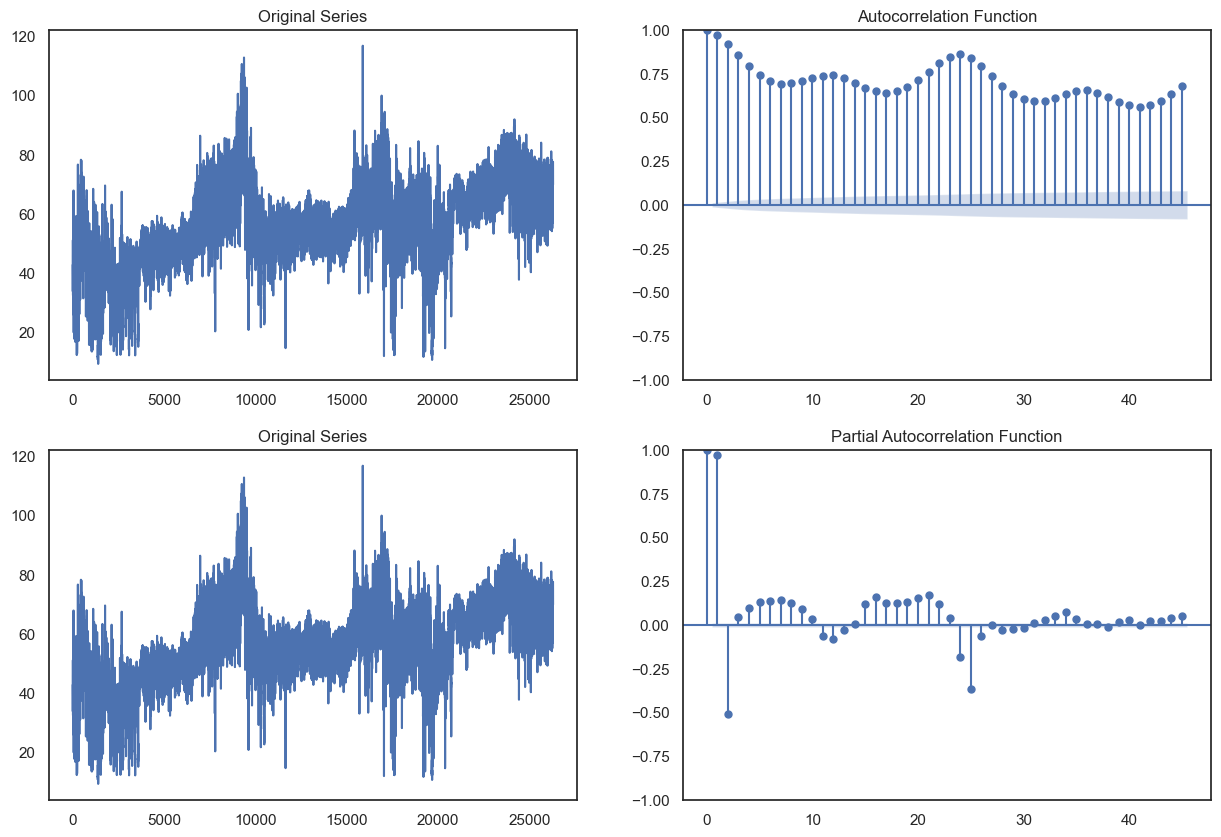

In [18]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].plot(energy_data['price actual'].values)
axes[0, 0].set_title('Original Series')
plot_acf(energy_data['price actual'], ax=axes[0, 1])
axes[0, 1].set_title('Autocorrelation Function')

axes[1, 0].plot(energy_data['price actual'].values)
axes[1, 0].set_title('Original Series')
plot_pacf(energy_data['price actual'], ax=axes[1, 1])
axes[1, 1].set_title('Partial Autocorrelation Function')

plt.show()

As it is normal in timeseries, we can definitly see some interesting auto and partial autocorrelations within our target value. This tells us that generating lag features (i.e.: shifting backwards the a previous value of the series observed at a specific time point) should help our model.

According to these results 1h, 3h, 6h, 12 and 24h look like interesting lag features to explore.

### Additional EDA

In addition to the points showed above, I've also ran a ```ProfileReport``` on the target data by the use of the following code that generated the profile_report.html file made available in this repo.

```
from ydata_profiling import ProfileReport

profile = ProfileReport(energy_data, tsmode=True, sortby="time")
profile.to_file('profile_report.html')
```

The reason why I don't include this code in the notebook is because I had some troubles installing the ```ProfileReport``` module and don't want the reviewer colleagues going thru the same hassle.

You can refer to the report result to understand better seasonality and estationarity properties of the data as well as many other details.

In [19]:
#from ydata_profiling import ProfileReport
#
#profile = ProfileReport(energy_data[numerical + ['time_str']], tsmode=True, sortby="time_str")
#profile.to_file('EDA_profile_report.html')

### Conclusion
To wrap-up the data exploration I summarize below the main findings to take into consideration going forward:
* We will train the model on periods after 2016 due to different generation mix.
* We will fill-in null values with intrapolations.
* We will include all columns except for the ones that are mostly empy.
* We will create lag variables for 1h, 3h, 6h, 12h and 24h.
* We will need to scale the values to adjust for seasonality and trends.
* We know some features are skewed, but we will let it be for the moment.

## Model selection

So the purpose of the current exercise is to predict with 1h in advance the price of electricity given the information available at the moment, i.e.:
* the generation mix - how much is generation source is producing
* the demand for electricity (and the estimated demand for the next day)
* the history of the price (and the day ahead price as given by the market)

This might not be most practical of the applications as some of this data is not made available in real time, but it helps us establish the predictive power of these variables alongside with a Neural Network that can then be expaneded based on windows and forecast horizons for more pratical use.

For this particular exercise we will only be focusing on predicting for the next hour given the values of the current hour. As such we need to start by establishing the baseline, i.e.: what are we going to compare our model agaisnt.

To make it simple, let's just use the value of the price at a given time and evaluate its Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE) against the next hour which will be our baseline. To be clear, our evaluation metric will be RMSE, I will be including MAE just to have a better grasp at how the model is evolving.

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
baseline_predictions = energy_data['price actual'].shift(-1).dropna()
baseline_rmse = np.sqrt(mean_squared_error(energy_data['price actual'][:-1], baseline_predictions))
baseline_mae = mean_absolute_error(energy_data['price actual'][:-1], baseline_predictions)

print(f'RMSE: {baseline_rmse:.2f}')
print(f'MAE: {baseline_mae:.2f}')

RMSE: 3.40
MAE: 2.33


Our goal now is to create a deep learning model that can beat 3.40 RMSE. Let's start by preparing the data by adding the lag features and other contextual time data.

### Data Prep

In [21]:
model_data = energy_data[numerical + ['time']].copy()

# Create contextual features from the date
model_data['year'] = model_data['time'].dt.year
model_data['month'] = model_data['time'].dt.month
model_data['day'] = model_data['time'].dt.day
model_data['hour'] = model_data['time'].dt.hour
model_data['dayofweek'] = model_data['time'].dt.dayofweek

# Create lag features
model_data['price_actual_lag24h'] = model_data['price actual'].shift(24)
model_data['price_actual_lag12h'] = model_data['price actual'].shift(12)
model_data['price_actual_lag6h'] = model_data['price actual'].shift(6)
model_data['price_actual_lag3h'] = model_data['price actual'].shift(3)
model_data['price_actual_lag1h'] = model_data['price actual'].shift(1)

# We need to drop the nulls that were introducted with the shifts
model_data = model_data.dropna(how='any', axis=0)

Next, let's split the data in training and test data and scale the data as per our previous analysis. Let's use 18 months for training and leave 6 months the end for testing.

In [22]:
train_data = model_data[(model_data['time'] >= '2016-01-01') & (model_data['time'] < '2017-06-01')]
test_data = model_data[model_data['time'] >= '2017-06-01']

timestamps_train = train_data['time']
timestamps_test = test_data['time']

# Separate features and target for train and test
# Note we are including 'price actual' in the dataset because our target variable is actually the shift by 1h of this variable
X_train = train_data.drop(columns=['time'])[:-1]
y_train = train_data['price actual'].shift(-1).dropna()

X_test = test_data.drop(columns=['time'])[:-1]
y_test = test_data['price actual'].shift(-1).dropna()

Finally, let's normalize the data.

In [23]:
from sklearn.preprocessing import MinMaxScaler

# Normalize features using MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape the input data for LSTM (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

### Model Selection

When dealing with timeseries there are two main deep learning models that should be considered: Recurrent Neural Networks (RNN) and Long Short Term Memory (LSTM).

As such, I will start our model search by testing single layered models of RNNs, LSTM and 1D Convolutional neural network as well as stacked versions of those - stacked RNN, stacked LSTM and CNN with both RNN and LSTM. In total I will test try with 9 models:
* Single LSTM layer
* Single RNN layer
* Single 1D Convolutional (CNN) layer
* Stacked RNN layer
* Stacked LSTM layer
* CNN with an addittional LSTM layer
* CNN with an addittional RNN layer
* 
I will start with ChatGPT suggested sizes for each and then fine-tune the best one.

For each model I will test several drop levels (50%, 10% and 0%) to see the effect of drop on each of the models.

Let's then start by importing tensorflow and keras and creating these models.

In [24]:
import tensorflow as tf
import keras

keras.utils.set_random_seed(812)
tf.config.experimental.enable_op_determinism()

2023-12-19 12:51:05.726504: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Conv1D, Flatten, SimpleRNN

# Model 1: simple LSTM
def simple_lstm_builder(dropout_rate):
    simple_lstm = Sequential()
    simple_lstm.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
    simple_lstm.add(Dropout(dropout_rate))
    simple_lstm.add(Dense(1))
    simple_lstm.compile(optimizer='adam', loss='mean_squared_error')
    return simple_lstm

# Model 2: simple RNN
def simple_rnn_builder(dropout_rate):
    simple_rnn = Sequential()
    simple_rnn.add(SimpleRNN(50, input_shape=(X_train.shape[1], X_train.shape[2])))
    simple_rnn.add(Dropout(dropout_rate))
    simple_rnn.add(Dense(1))
    simple_rnn.compile(optimizer='adam', loss='mean_squared_error')
    return simple_rnn

# Model 3: simple CNN
def simple_cnn_builder(dropout_rate):
    simple_cnn = Sequential()
    simple_cnn.add(Conv1D(filters=48, kernel_size=2, activation='relu', padding='same', input_shape=(X_train.shape[1], X_train.shape[2])))
    simple_cnn.add(Flatten())
    simple_cnn.add(Dropout(dropout_rate))
    simple_cnn.add(Dense(1))
    simple_cnn.compile(optimizer='adam', loss='mean_squared_error')
    return simple_cnn

# Model 4: Dual LSTM
def dual_lstm_builder(dropout_rate):
    dual_lstm = Sequential()
    dual_lstm.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    dual_lstm.add(LSTM(25))
    dual_lstm.add(Dropout(dropout_rate))
    dual_lstm.add(Dense(1))
    dual_lstm.compile(optimizer='adam', loss='mean_squared_error')
    return dual_lstm

# Model 5: Dual RNN
def dual_rnn_builder(dropout_rate):
    dual_rnn = Sequential()
    dual_rnn.add(SimpleRNN(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    dual_rnn.add(SimpleRNN(25))
    dual_rnn.add(Dropout(dropout_rate))
    dual_rnn.add(Dense(1))
    dual_rnn.compile(optimizer='adam', loss='mean_squared_error')
    return dual_rnn

# Model 6: CNN + LSTM
def cnn_lstm_builder(dropout_rate):
    cnn_lstm = Sequential()
    cnn_lstm.add(Conv1D(filters=48, kernel_size=2, activation='relu', padding='same', input_shape=(X_train.shape[1], X_train.shape[2])))
    cnn_lstm.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
    cnn_lstm.add(Flatten())
    cnn_lstm.add(Dropout(dropout_rate))
    cnn_lstm.add(Dense(1))
    cnn_lstm.compile(optimizer='adam', loss='mean_squared_error')
    return cnn_lstm

# Model 7: CNN + RNN
def cnn_rnn_builder(dropout_rate):
    cnn_rnn = Sequential()
    cnn_rnn.add(Conv1D(filters=48, kernel_size=2, activation='relu', padding='same', input_shape=(X_train.shape[1], X_train.shape[2])))
    cnn_rnn.add(SimpleRNN(50, input_shape=(X_train.shape[1], X_train.shape[2])))
    cnn_rnn.add(Flatten())
    cnn_rnn.add(Dropout(dropout_rate))
    cnn_rnn.add(Dense(1))
    cnn_rnn.compile(optimizer='adam', loss='mean_squared_error')
    return cnn_rnn

# Model 8: LSTM + RNN
def lstm_rnn_builder(dropout_rate):
    lstm_rnn = Sequential()
    lstm_rnn.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    lstm_rnn.add(SimpleRNN(25, input_shape=(X_train.shape[1], X_train.shape[2])))
    lstm_rnn.add(Dropout(dropout_rate))
    lstm_rnn.add(Dense(1))
    lstm_rnn.compile(optimizer='adam', loss='mean_squared_error')
    return lstm_rnn

# Model 9: RNN + LSTM
def rnn_lstm_builder(dropout_rate):
    rnn_lstm = Sequential()
    rnn_lstm.add(SimpleRNN(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    rnn_lstm.add(LSTM(25, input_shape=(X_train.shape[1], X_train.shape[2])))
    rnn_lstm.add(Flatten())
    rnn_lstm.add(Dropout(dropout_rate))
    rnn_lstm.add(Dense(1))
    rnn_lstm.compile(optimizer='adam', loss='mean_squared_error')
    return rnn_lstm

Great, so now let's instantiate the models

In [26]:
dropout_rates = [0.5, 0.1, 0]

base_models = [
    ("Simple LSTM", simple_lstm_builder), 
    ("Simple RNN", simple_rnn_builder), 
    ("Simple CNN", simple_cnn_builder),
    ("Dual LSTM", dual_lstm_builder),
    ("Dual RNN", dual_rnn_builder),
    ("CNN + LSTM", cnn_lstm_builder),
    ("CNN + RNN", cnn_rnn_builder),
    ("LSTM + RNN", lstm_rnn_builder),
    ("RNN + LSTM", rnn_lstm_builder)]

model_instances = []

for model_name, model in base_models:
    for dropout_rate in dropout_rates:
         model_instances.append((f'{model_name} @ {dropout_rate:.2f} dropout', model(dropout_rate), dropout_rate))

Ok so now let's compute!

#### (!) Attention code below is computational heavy (!) ####

In [27]:
early_stopping = [tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 3)]
epochs = 20

model_results = []


for model_name, model, dropout_rate in model_instances:
    print(f'### Training: {model_name}')
    history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), callbacks = early_stopping, verbose=0)
    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']
    final_train_loss = training_loss[-1]
    final_val_loss = validation_loss[-1]
    epoch_num = len(history.history["loss"])
    print(f'Finished training after {epoch_num} epochs')
    print(f'Final training loss: {final_train_loss:.2f} | Final validation loss {final_train_loss:.2f}')
    predictions = model.predict(X_test, verbose=0)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    mae = mean_absolute_error(y_test, predictions)
    print(f'RMSE: {rmse:.2f} | MAE: {mae:.2f}')
    model_results.append((model_name, history, rmse, mae))

### Training: Simple LSTM @ 0.50 dropout
Finished training after 20 epochs
Final training loss: 71.33 | Final validation loss 71.33
RMSE: 4.52 | MAE: 3.37
### Training: Simple LSTM @ 0.10 dropout
Finished training after 20 epochs
Final training loss: 22.00 | Final validation loss 22.00
RMSE: 3.96 | MAE: 2.96
### Training: Simple LSTM @ 0.00 dropout
Finished training after 20 epochs
Final training loss: 12.26 | Final validation loss 12.26
RMSE: 3.98 | MAE: 3.01
### Training: Simple RNN @ 0.50 dropout
Finished training after 20 epochs
Final training loss: 72.37 | Final validation loss 72.37
RMSE: 4.77 | MAE: 3.64
### Training: Simple RNN @ 0.10 dropout
Finished training after 20 epochs
Final training loss: 22.62 | Final validation loss 22.62
RMSE: 3.99 | MAE: 2.98
### Training: Simple RNN @ 0.00 dropout
Finished training after 20 epochs
Final training loss: 11.80 | Final validation loss 11.80
RMSE: 4.33 | MAE: 3.34
### Training: Simple CNN @ 0.50 dropout
Finished training after 20 epochs

Ok, so despite the early stopping all models went up to 20 epochs which tells us that maybe there would be a bit more room to extract improvements with further epochs. 

Let's have a look at how the results look like:

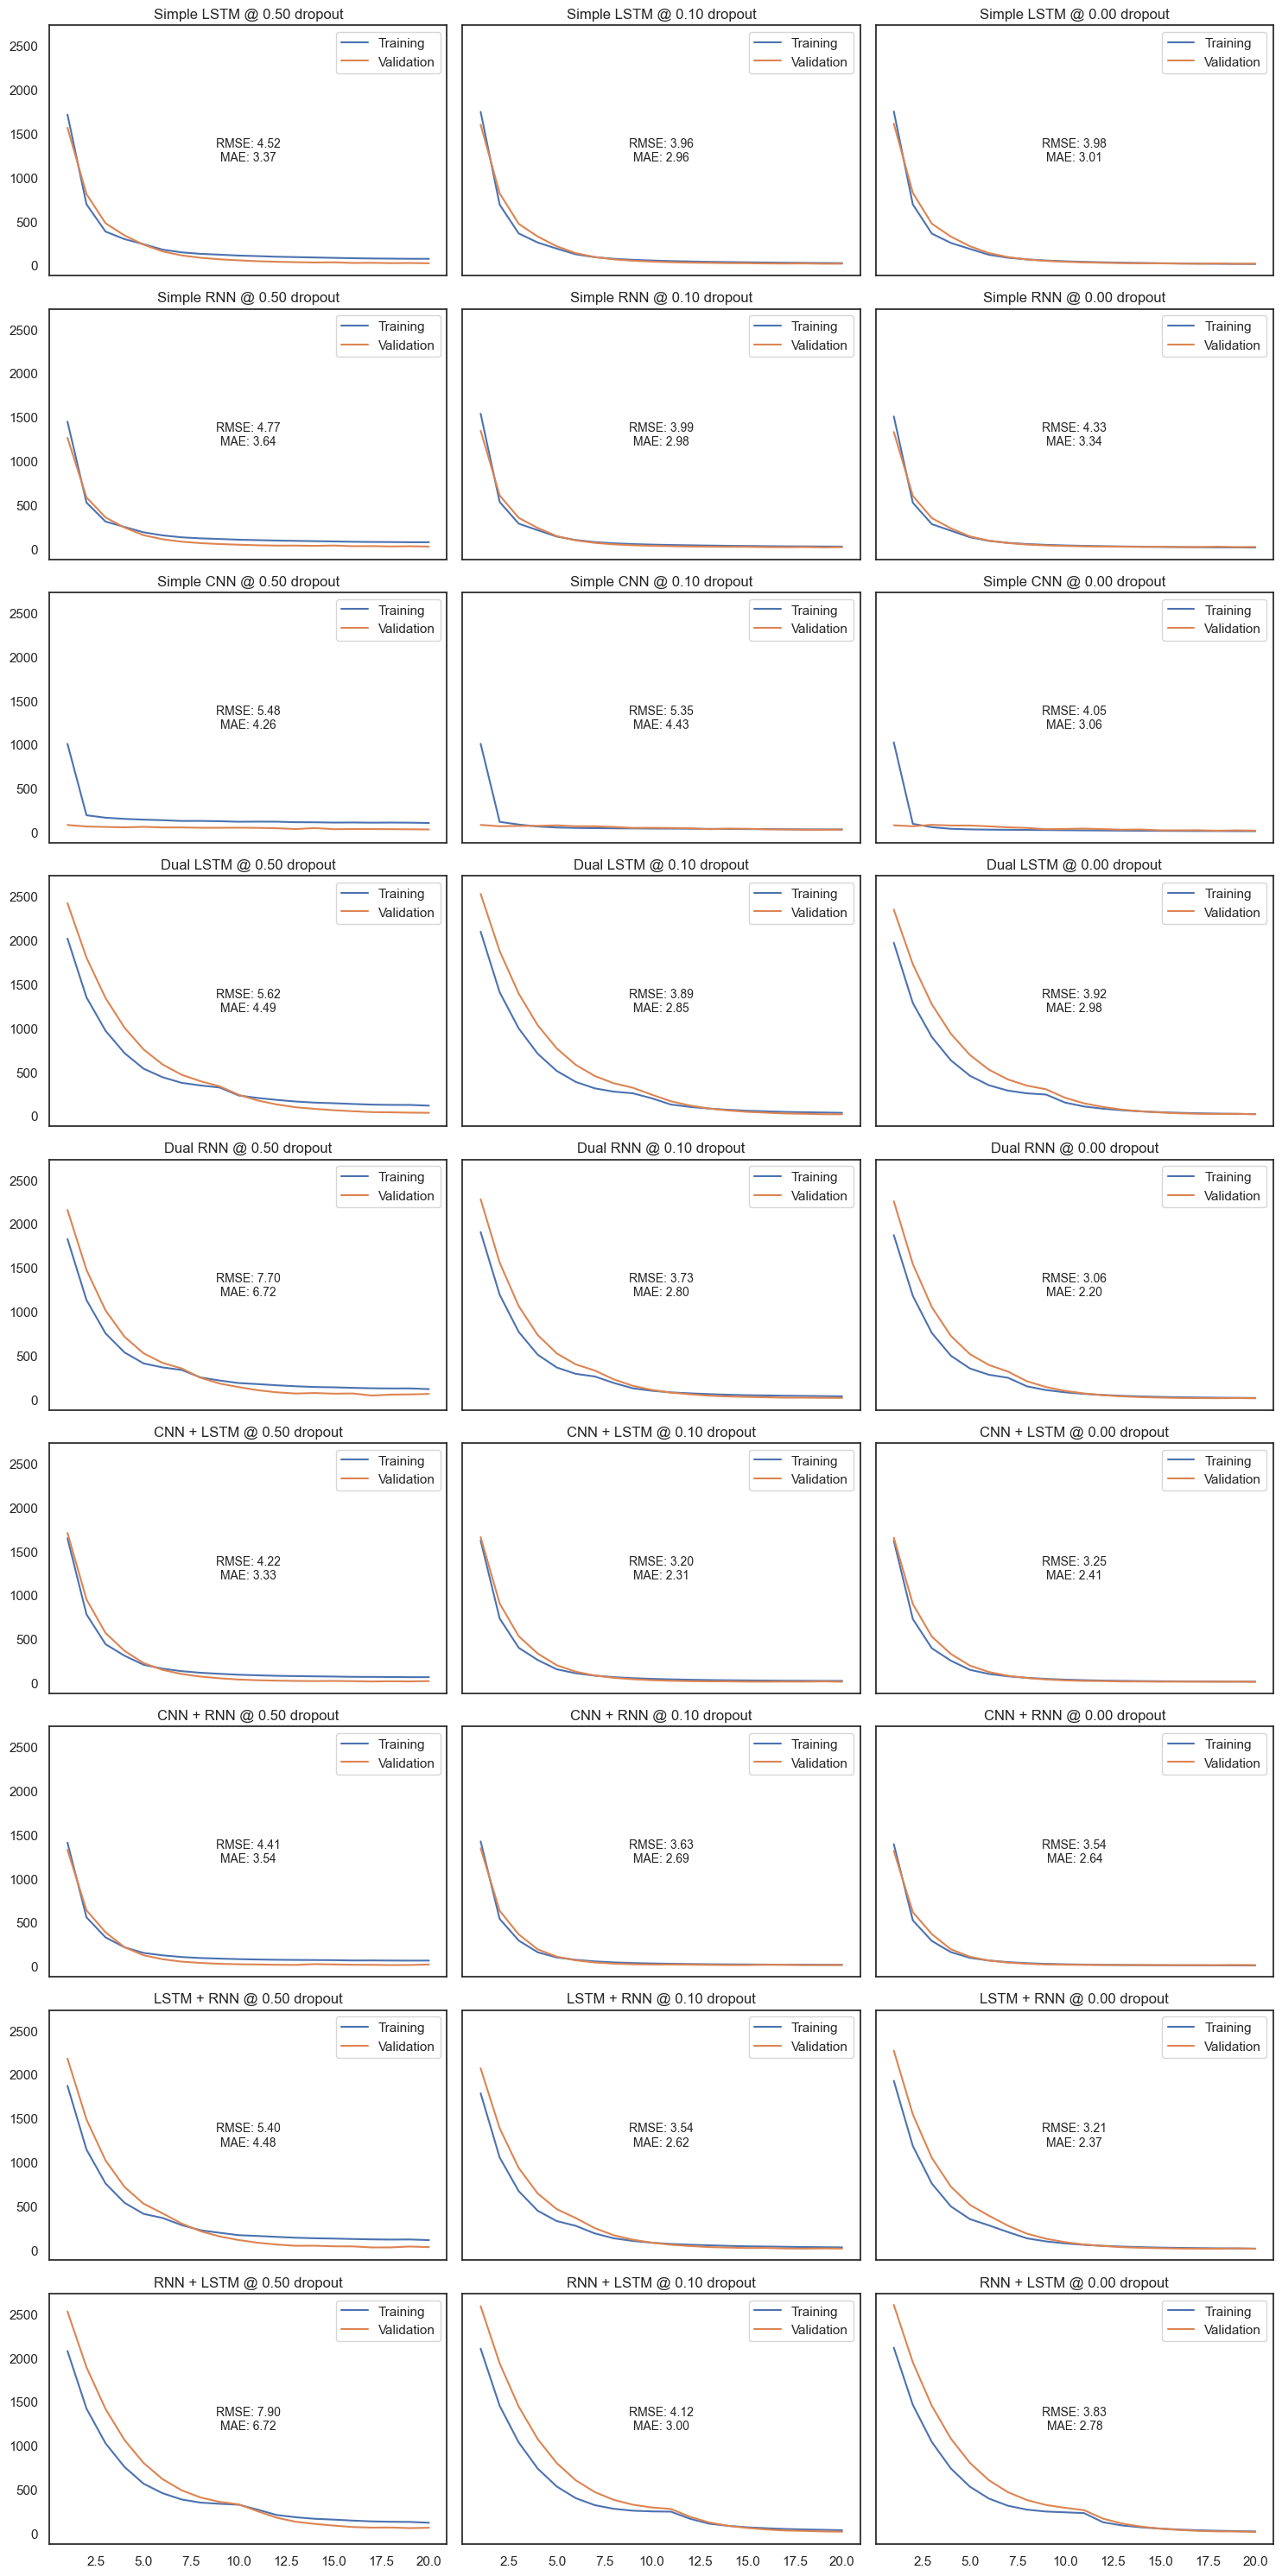

In [28]:
# Create a 3x9 subplot grid
fig, axes = plt.subplots(9, 3, figsize=(15, 30), sharex=True, sharey=True)

# Flatten the 3x9 grid to iterate through each subplot
axes = axes.flatten()

for i, (model_name, _, _, _) in enumerate(model_results):
    ax = axes[i]
    
    # Plot training and validation loss curves
    history = next(history for name, history, _, _ in model_results if name == model_name)
    sns.lineplot(x=range(1, len(history.history['loss']) + 1), y=history.history['loss'], label='Training', ax=ax)
    sns.lineplot(x=range(1, len(history.history['val_loss']) + 1), y=history.history['val_loss'], label='Validation', ax=ax)
    
    # Add a text box with RMSE and MAE results
    rmse, mae = next((rmse, mae) for name, _, rmse, mae in model_results if name == model_name)
    textstr = f'RMSE: {rmse:.2f}\nMAE: {mae:.2f}'
    ax.text(0.5, 0.5, textstr, transform=ax.transAxes, fontsize=10, verticalalignment='center', horizontalalignment='center',
            bbox=dict(facecolor='white', edgecolor='white', boxstyle='round,pad=0.3'))

    # Set subplot title
    ax.set_title(model_name)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

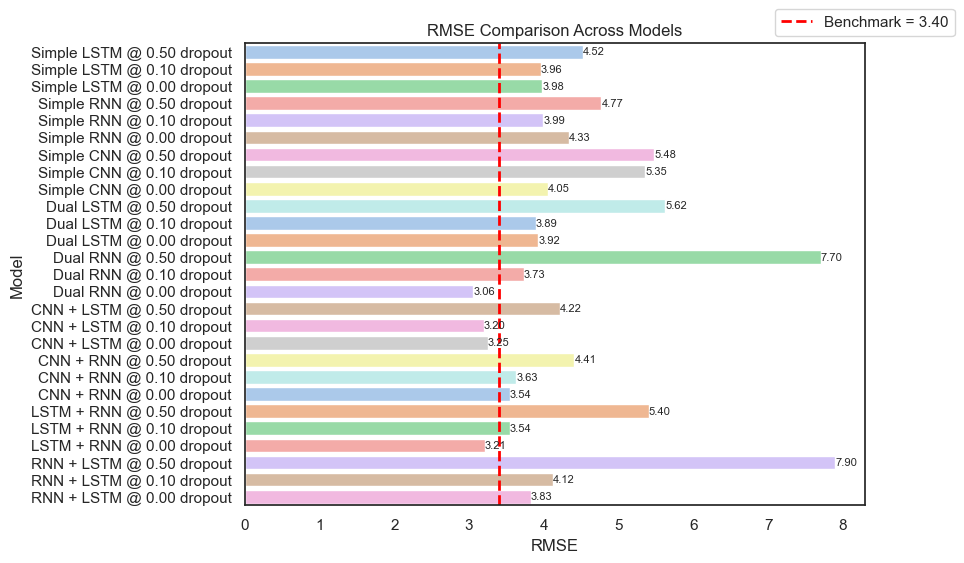

In [29]:
# Extract model names and corresponding RMSE values
model_names = [name for name, _, _, _ in model_results]
rmse_values = [rmse for _, _, rmse, _ in model_results]

# Create a bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x=rmse_values, y=model_names, palette='pastel')
plt.xlabel('RMSE')
plt.ylabel('Model')
plt.title('RMSE Comparison Across Models')

# Add RMSE values at the end of each bar
for i, value in enumerate(rmse_values):
    plt.text(value, i, f'{value:.2f}', va='center', ha='left', fontsize=8)

# Add a benchmark line
plt.axvline(3.40, color='red', linestyle='--', linewidth=2, label='Benchmark = 3.40')

plt.legend(loc='lower center', bbox_to_anchor=(1,1))
plt.show()

NOTE: if you re-run the the code you might get different results, so you'll need to assume the narrative is correct (check git for my output at the moment of writing)

Great news - we could already beat out benchmark with a couple of models.

Overall, dropout rate doesn't seem to add much except on a few exceptional cases where the 10% dropout beats the model without dropout.

Let's have a detailed look at each one:
* *Simple LSTM*: Model doesn't beat the benchmark.
* *Simple RNN*: Model doesn't beat the benchmark. One of the few cases where small dropout beats without dropout.
* *Simple CNN*: Convolutional layer by itself doesn't solve well for this problem - standalone LSTM and RNN work best.
* *Dual LSTM*: Adding another LSTM layer doesn't add that much performance vs. single LSTM layer.
* *Dual RNN*: Bingo! Adding the inner RNN layer and removing the dropout beats the benchmark! Best performance registered.
* *CNN + LSMT*: Second best performing model and already beats the benchmark with 10% dropout and also without drop. Solid architectural choice.
* *CNN + RNN*: Curiously adding an RNN layer to the CNN, contraty to the LSTM, doesn't improve performance.
* *LSTM + RNN*: Adding an RNN layer layer to an initial LSTM layer seems to lead to good results and can even beat our benchmark without dropout.
* *RNN + LSTM*: The contrary (adding an LSTM layer to an RNN layer) doesn't seem to improve single RNN performance and doesn't beat the benchmark.

As a next step, let's try to squeeze some additional performance out of the best performing architcture - the Dual RNN layer - with a some fine-tuning.

### Fine-tuning

So we are going to fine-tune the Dual RNN model.

In our first attempt we started with a first layer of 50 units and an inner one of 25.

We are going to test with different layer sizes and optimize for learning rates later.

In [30]:
from tensorflow.keras.optimizers import Adam

def dual_rnn_fine_tune_builder(outter_layer_size, inner_layer_size, learning_rate=0.001):
    dual_rnn = Sequential()
    dual_rnn.add(SimpleRNN(outter_layer_size, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    dual_rnn.add(SimpleRNN(inner_layer_size))
    dual_rnn.add(Dropout(dropout_rate))
    dual_rnn.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    dual_rnn.compile(optimizer, loss='mean_squared_error')
    return dual_rnn

outter_layer_sizes = [25, 50, 100]
inner_layer_sizes = [15, 25, 50]

dual_rnn_instances = []

for outter_layer_size in outter_layer_sizes:
    for inner_layer_size in inner_layer_sizes:
        dual_rnn_instances.append((f'Dual RNN with {outter_layer_size} outter layer and {inner_layer_size} inner layer @ default learning rate', 
                                   dual_rnn_fine_tune_builder(outter_layer_size, inner_layer_size)))

In [31]:
early_stopping = [tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 3)]
epochs = 50

fine_tune_results = []

for model_name, model in dual_rnn_instances:
    print(f'### Training: {model_name}')
    history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), callbacks = early_stopping, verbose=0)
    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']
    final_train_loss = training_loss[-1]
    final_val_loss = validation_loss[-1]
    epoch_num = len(history.history["loss"])
    print(f'Finished training after {epoch_num} epochs')
    print(f'Final training loss: {final_train_loss:.2f} | Final validation loss {final_train_loss:.2f}')
    predictions = model.predict(X_test, verbose=0)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    mae = mean_absolute_error(y_test, predictions)
    print(f'RMSE: {rmse:.2f} | MAE: {mae:.2f}')
    fine_tune_results.append((model_name, history, rmse, mae))

### Training: Dual RNN with 25 outter layer and 15 inner layer @ default learning rate
Finished training after 50 epochs
Final training loss: 6.78 | Final validation loss 6.78
RMSE: 2.97 | MAE: 2.17
### Training: Dual RNN with 25 outter layer and 25 inner layer @ default learning rate
Finished training after 50 epochs
Final training loss: 6.48 | Final validation loss 6.48
RMSE: 3.20 | MAE: 2.42
### Training: Dual RNN with 25 outter layer and 50 inner layer @ default learning rate
Finished training after 37 epochs
Final training loss: 6.87 | Final validation loss 6.87
RMSE: 3.16 | MAE: 2.40
### Training: Dual RNN with 50 outter layer and 15 inner layer @ default learning rate
Finished training after 50 epochs
Final training loss: 6.43 | Final validation loss 6.43
RMSE: 3.03 | MAE: 2.25
### Training: Dual RNN with 50 outter layer and 25 inner layer @ default learning rate
Finished training after 50 epochs
Final training loss: 6.19 | Final validation loss 6.19
RMSE: 2.82 | MAE: 2.06
### T

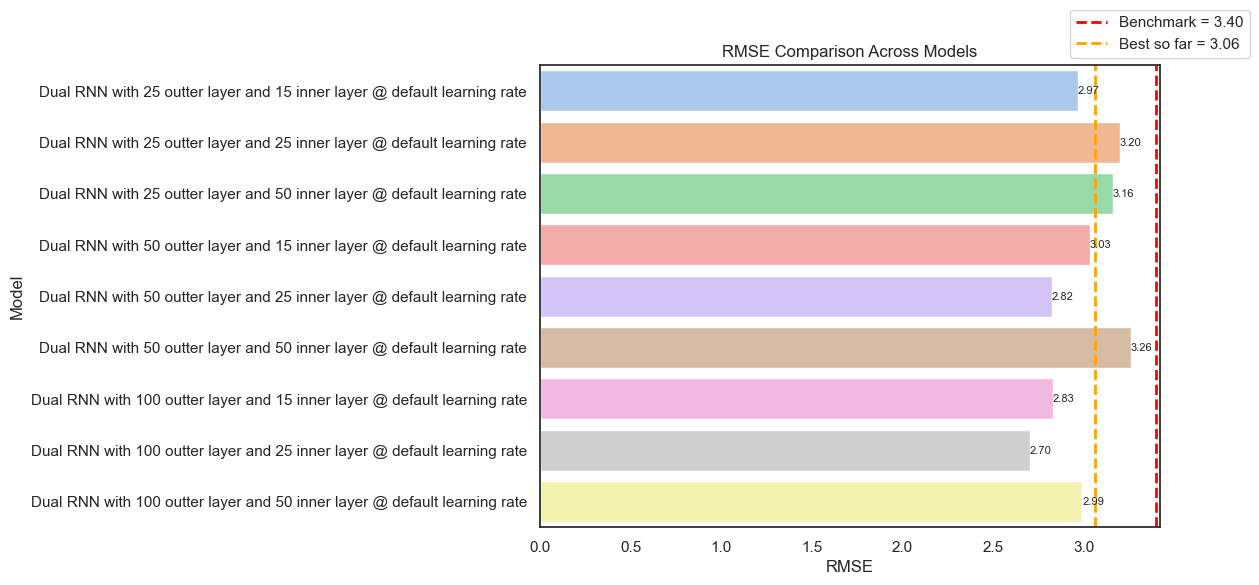

In [32]:
# Extract model names and corresponding RMSE values
model_names = [name for name, _, _, _ in fine_tune_results]
rmse_values = [rmse for _, _, rmse, _ in fine_tune_results]

# Create a bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x=rmse_values, y=model_names, palette='pastel')
plt.xlabel('RMSE')
plt.ylabel('Model')
plt.title('RMSE Comparison Across Models')

# Add RMSE values at the end of each bar
for i, value in enumerate(rmse_values):
    plt.text(value, i, f'{value:.2f}', va='center', ha='left', fontsize=8)

# Add a benchmark line
plt.axvline(3.40, color='red', linestyle='--', linewidth=2, label='Benchmark = 3.40')
plt.axvline(3.06, color='orange', linestyle='--', linewidth=2, label='Best so far = 3.06')

plt.legend(loc='lower center', bbox_to_anchor=(1,1))
plt.show()

Dual RNN layer without dropout is consistently better than the established benchmark.

A larger outter layer with a small inner layer seems be yield the best results and we can beat our previous record with several configurations.

Best result seems to be with 100 outter layer and 25 inner layer, so before we set ourselves on that solution, let's just try with yet an additional inner layer of 15 since the results with a 15 layer also showed promising.

In [33]:
deep_triple_rnn = Sequential()
deep_triple_rnn.add(SimpleRNN(100, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
deep_triple_rnn.add(SimpleRNN(25, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
deep_triple_rnn.add(SimpleRNN(15, input_shape=(X_train.shape[1], X_train.shape[2])))
deep_triple_rnn.add(Flatten())
deep_triple_rnn.add(Dense(1))
deep_triple_rnn.compile(optimizer='adam', loss='mean_squared_error')

deep_triple_rnn.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), callbacks = early_stopping, verbose=1)
deep_triple_rnn_predictions = deep_dual_rnn.predict(X_test, verbose=1)
rmse = np.sqrt(mean_squared_error(y_test, deep_triple_rnn_predictions))
mae = mean_absolute_error(y_test, deep_triple_rnn_predictions)
print(f'RMSE: {rmse:.2f} | MAE: {mae:.2f}')

Epoch 1/50
387/387 [==============================] - 5s 6ms/step - loss: 2204.0298 - val_loss: 2845.0388
Epoch 2/50
387/387 [==============================] - 2s 5ms/step - loss: 1687.0774 - val_loss: 2279.4399
Epoch 3/50
387/387 [==============================] - 1s 3ms/step - loss: 1297.3766 - val_loss: 1817.4264
Epoch 4/50
387/387 [==============================] - 1s 3ms/step - loss: 991.4556 - val_loss: 1440.5140
Epoch 5/50
387/387 [==============================] - 1s 3ms/step - loss: 754.9975 - val_loss: 1135.5647
Epoch 6/50
387/387 [==============================] - 1s 3ms/step - loss: 577.0868 - val_loss: 892.6680
Epoch 7/50
387/387 [==============================] - 1s 3ms/step - loss: 448.1616 - val_loss: 703.6851
Epoch 8/50
387/387 [==============================] - 1s 3ms/step - loss: 358.9804 - val_loss: 560.1135
Epoch 9/50
387/387 [==============================] - 1s 3ms/step - loss: 301.0728 - val_loss: 454.3167
Epoch 10/50
387/387 [==============================] - 1

NameError: name 'deep_dual_rnn' is not defined

Seems like adding yet another extra layer doesn't help so let's keep our best configuration so far: 100 outter layer and 25 inner layer and let's just try to optimize the learning rate to see what we get.

In [34]:
learning_rates = [0.0001, 0.001, 0.01, 0.1]

dual_rnn_100_25_instances = []

for learning_rate in learning_rates:
    dual_rnn_100_25_instances.append((f'Training Dual RNN with 100 outter layer and 25 inner layer @ {learning_rate:.4f} learning rate',
                                      dual_rnn_fine_tune_builder(100, 25, learning_rate)))

In [35]:
early_stopping = [tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 3)]
epochs = 50

fine_tune_results = []

for model_name, model in dual_rnn_100_25_instances:
    print(f'### Training: {model_name}')
    history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), callbacks = early_stopping, verbose=0)
    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']
    final_train_loss = training_loss[-1]
    final_val_loss = validation_loss[-1]
    epoch_num = len(history.history["loss"])
    print(f'Finished training after {epoch_num} epochs')
    print(f'Final training loss: {final_train_loss:.2f} | Final validation loss {final_train_loss:.2f}')
    predictions = model.predict(X_test, verbose=0)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    mae = mean_absolute_error(y_test, predictions)
    print(f'RMSE: {rmse:.2f} | MAE: {mae:.2f}')
    fine_tune_results.append((model_name, history, rmse, mae))

### Training: Training Dual RNN with 100 outter layer and 25 inner layer @ 0.0001 learning rate
Finished training after 50 epochs
Final training loss: 131.21 | Final validation loss 131.21
RMSE: 14.94 | MAE: 12.30
### Training: Training Dual RNN with 100 outter layer and 25 inner layer @ 0.0010 learning rate
Finished training after 50 epochs
Final training loss: 6.04 | Final validation loss 6.04
RMSE: 3.11 | MAE: 2.31
### Training: Training Dual RNN with 100 outter layer and 25 inner layer @ 0.0100 learning rate
Finished training after 18 epochs
Final training loss: 9.12 | Final validation loss 9.12
RMSE: 5.09 | MAE: 4.03
### Training: Training Dual RNN with 100 outter layer and 25 inner layer @ 0.1000 learning rate
Finished training after 6 epochs
Final training loss: 237.29 | Final validation loss 237.29
RMSE: 17.03 | MAE: 14.37


Ok, changing the learning rate doesn't seem to help, so let's just call it the best model a Stacked Recurrent Neural Network with 100 outter layer and 25 inner layer with a learning rate of 0.001 and let's optimize for epochs to prepare the training script.

Let's let it run for 150 epochs and create a check-point for the minimum loss so that we can then use it as our model in production instead of training a new one that might come with a differnt peformance.

In [37]:
selected_model = dual_rnn_fine_tune_builder(100,25,0.001)

checkpoint = keras.callbacks.ModelCheckpoint(
    'checkpoints/best-model_v1_{epoch:02d}_{val_loss:02f}.h5',
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)

selected_model.fit(X_train, y_train, epochs=150, validation_data=(X_test, y_test), callbacks = checkpoint, verbose=1)

Epoch 1/150
387/387 [==============================] - 2s 3ms/step - loss: 1837.6260 - val_loss: 2230.5974
Epoch 2/150
112/387 [=======>......................] - ETA: 0s - loss: 1346.8242

/usr/local/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


387/387 [==============================] - 1s 2ms/step - loss: 1161.9159 - val_loss: 1523.9437
Epoch 3/150
387/387 [==============================] - 1s 2ms/step - loss: 744.4916 - val_loss: 1036.8025
Epoch 4/150
387/387 [==============================] - 1s 2ms/step - loss: 489.3225 - val_loss: 713.6083
Epoch 5/150
387/387 [==============================] - 1s 2ms/step - loss: 346.6676 - val_loss: 508.6584
Epoch 6/150
387/387 [==============================] - 1s 2ms/step - loss: 276.4156 - val_loss: 386.2624
Epoch 7/150
387/387 [==============================] - 1s 2ms/step - loss: 214.1175 - val_loss: 279.9110
Epoch 8/150
387/387 [==============================] - 1s 2ms/step - loss: 131.8245 - val_loss: 186.7776
Epoch 9/150
387/387 [==============================] - 1s 2ms/step - loss: 96.0648 - val_loss: 127.7348
Epoch 10/150
387/387 [==============================] - 1s 2ms/step - loss: 72.4378 - val_loss: 86.7077
Epoch 11/150
387/387 [==============================] - 1s 2ms/ste

Let's just double-check how the final model performs

In [41]:
final_model = keras.models.load_model('checkpoints/best-model_v1_36_8.344853.h5')

In [42]:
final_model_predictions = final_model.predict(X_test, verbose=0)
rmse = np.sqrt(mean_squared_error(y_test, final_model_predictions))
mae = mean_absolute_error(y_test, final_model_predictions)
print(f'RMSE: {rmse:.2f} | MAE: {mae:.2f}')

RMSE: 2.89 | MAE: 2.13


Not the bet performance we got historically with this model, but still a very good one - better than the benchmark and better than all the models trained at first, which means that we could improve based on fine tuning.

## Conclusion and results visualization

Ok, so we proved that we are able to better predict the price of electricity for the next hour with a neural network than simply guessing it based on the previous hour.

For that, we've build an Stacked Recurrent Neural Network, with an outter layer of 100 and an additional inner layer of 25. Adam with 0.001 learning rate seems to be the best optimizer.

For our training script we will set epoch at 35 to prevent overfitting we saw in the last training round.

Below you can see how 2 weeks of actual data compares with our projections alongside with the naive predictor that we've started with (previous hour).

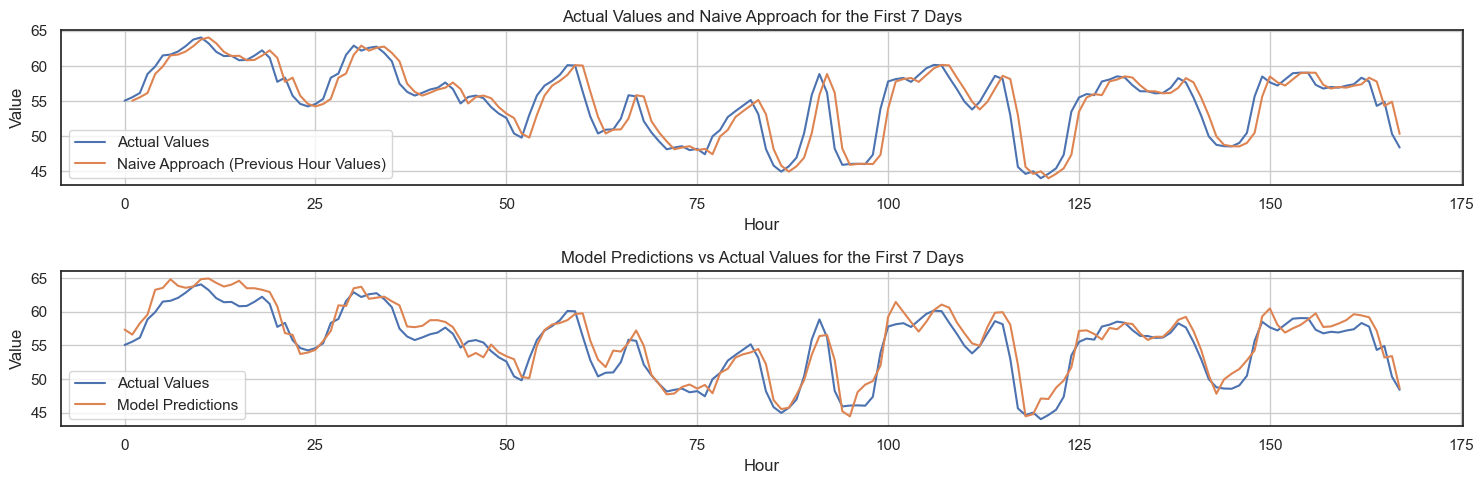

In [43]:
num_data_points = 24*7

# First subplot: Actual values and naive approach
plt.subplot(2, 1, 1)
plt.plot(np.arange(num_data_points), y_test[:num_data_points], label='Actual Values')
plt.plot(np.arange(num_data_points), y_test[:num_data_points].shift(1), label='Naive Approach (Previous Hour Values)')
plt.title('Actual Values and Naive Approach for the First 7 Days')
plt.xlabel('Hour')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

# Second subplot: Model predictions and actual values
plt.subplot(2, 1, 2)
plt.plot(np.arange(num_data_points), y_test[:num_data_points], label='Actual Values')
plt.plot(np.arange(num_data_points), final_model_predictions[:num_data_points], label='Model Predictions')
plt.title('Model Predictions vs Actual Values for the First 7 Days')
plt.xlabel('Hour')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

# Adjust layout for better spacing
plt.tight_layout()

plt.show()

In [48]:
test_data.head(1)

'{"generation biomass":{"21169":349.0},"generation fossil brown coal\\/lignite":{"21169":634.0},"generation fossil gas":{"21169":5399.0},"generation fossil hard coal":{"21169":5557.0},"generation fossil oil":{"21169":282.0},"generation hydro pumped storage consumption":{"21169":1056.0},"generation hydro run-of-river and poundage":{"21169":468.0},"generation hydro water reservoir":{"21169":442.0},"generation nuclear":{"21169":7100.0},"generation other":{"21169":58.0},"generation other renewable":{"21169":104.0},"generation solar":{"21169":30.0},"generation waste":{"21169":338.0},"generation wind onshore":{"21169":4607.0},"forecast solar day ahead":{"21169":10.0},"forecast wind onshore day ahead":{"21169":4642.0},"total load actual":{"21169":22472.0},"total load forecast":{"21169":23137.0},"price day ahead":{"21169":52.11},"price actual":{"21169":56.6},"time":{"21169":1496275200000},"year":{"21169":2017},"month":{"21169":6},"day":{"21169":1},"hour":{"21169":0},"dayofweek":{"21169":3},"pr